# HUHU@IberLEF2023 Task 1 (Binary Classification)

Task: https://sites.google.com/view/huhuatiberlef23/huhu

This notebook contains the code to fine-tune several pre-trained transformers for the task of hurtful humour detection (binary classification).

In particular, the models are:

* BERT Multilingual: ``bert-base-multilingual-cased`` and ``bert-base-multilingual-uncased``
* RoBERTa: ``roberta-base``
* BETO: ``dccuchile/bert-base-spanish-wwm-cased`` and ``dccuchile/bert-base-spanish-wwm-uncased``
* DistilBERT Multilingual: ``distilbert-base-multilingual-cased``

To take advantage of these transformer models, different ensembles are configured resulting from all their possible combinations.

Experiments show that combining the prediction capabilities of these models allow to achieve better results than when used independently.

# Setting up the environment

In [ ]:
import torch

# Check GPU availability on Google Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

use_cuda = torch.cuda.is_available()

Thu Apr 27 10:24:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install libraries
!pip install simpletransformers
!pip install datasets
!pip install ipywidgets
!pip install --upgrade huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24

In [ ]:
# Define global variables

SEED = 42 # allow for experiments' reproductibility
WEIGHTED = True # use weighted ensemble (in favour of models with higher F1-score)

# Dataset load

In [ ]:
from huggingface_hub import notebook_login
# Notebook login via HF's token
notebook_login()

In [ ]:
from datasets import *
import pandas as pd

# Avoid warnings
logging.set_verbosity_error()

# Load training, validation and test splits
train = pd.DataFrame(load_dataset("huhu2023/bin-huhu2023", split="train"))
val = pd.DataFrame(load_dataset("huhu2023/bin-huhu2023", split="validation"))
test = pd.DataFrame(load_dataset("huhu2023/bin-huhu2023", split="test"))

train.head()

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/huhu2023___csv/huhu2023--bin-huhu2023-1e6f2f1b5c02adbb/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


,index,tweet,humor,prejudice_woman,prejudice_lgbtiq,prejudice_inmigrant_race,gordofobia,mean_prejudice
0,32261,MENTION La primera vez podría tomarse como que...,0,1,0,0,0,1.8
1,67362,¿Por qué Ricky Martin tardó tanto en salir del...,1,0,1,0,0,2.4
2,9818,"Van a cambiar las señales, porque un niño cogi...",0,1,0,0,0,2.0
3,4920,En que se parece una sirena y un transexual? E...,1,0,1,0,0,3.8
4,13205,La pelotuda esta MENTION comenzó todo ahora c...,0,1,0,0,0,2.4


In [ ]:
# Function to rename fields and drop unnecessary ones
def get_text_and_label(df, original_dataset=True):
  text_tag = "tweet" if original_dataset else "text"
  label_tag = "humor" if original_dataset else "is_humor"
  return df.rename(columns={text_tag: "text", label_tag: "label"})[["text", "label"]]

# Get treated dataframe for training, validation and test splits
train = get_text_and_label(train)
val = get_text_and_label(val)
test = get_text_and_label(test)

print(f"Dataset size: <{len(train.index)}:{len(val.index)}:{len(test.index)}>")
train.head()

Dataset size: <1869:535:267>


,text,label
0,MENTION La primera vez podría tomarse como que...,0
1,¿Por qué Ricky Martin tardó tanto en salir del...,1
2,"Van a cambiar las señales, porque un niño cogi...",0
3,En que se parece una sirena y un transexual? E...,1
4,La pelotuda esta MENTION comenzó todo ahora c...,0


# Dataset extension (HAHA@IberLEF2021)

In order to extend the size of the training and validation splits, the dataset provided at the HAHA competition (IberLEF2021) is used.

This dataset is publicly available at: https://www.fing.edu.uy/inco/grupos/pln/haha/index.html#data

**Note:** the test size will only contain instances from this year's competition in order to avoid undesirable biases in the resulting metrics.

In [ ]:
# Load training, validation and test splits
train_haha21 = pd.DataFrame(load_dataset("huhu2023/haha2021", split="train"))
val_haha21 = pd.DataFrame(load_dataset("huhu2023/haha2021", split="validation"))
test_haha21 = pd.DataFrame(load_dataset("huhu2023/haha2021", split="test"))

# Combine the previous splits into a unique pandas dataframe
df_haha21 = pd.concat([train_haha21, val_haha21, test_haha21], axis=0)

print("Dataset size:", len(df_haha21.index))
df_haha21.head()

In [ ]:
from sklearn.model_selection import train_test_split

# Rename the fields and drop the unnecessary ones
df_haha21 = get_text_and_label(df_haha21, original_dataset=False)

# Concat the training and validation datasets (HUHU23) with HAHA21's dataset
df_concat = pd.concat([train, val, df_haha21])

df_concat.head()

In [ ]:
# Get max split size under 50:50 balanced label
split_size = min(df_concat["label"].value_counts())

# IMPORTANT: the instances are not shuffled (i.e. sample function is not used)
# since it is convenient to use as many instances from this year's competition
# as possible
df_humor = df_concat.loc[df_concat["label"] == 1].iloc[:split_size]
df_no_humor = df_concat.loc[df_concat["label"] == 0].iloc[:split_size]

# Create a new class-balanced dataframe
df_concat = pd.concat([df_humor, df_no_humor])

# Generate new training and validation splits
train_text, val_text, train_label, val_label = train_test_split(df_concat["text"], df_concat["label"],
                                                                test_size=.2, stratify=df_concat["label"],
                                                                shuffle=True, random_state=SEED,)
train = pd.concat([train_text, train_label], axis=1)
val = pd.concat([val_text, val_label], axis=1)

In [ ]:
# Show some training instances
print(train["label"].value_counts())
train.head()

In [ ]:
# Show some validation instances
print(val["label"].value_counts())
val.head()

# Create output directory

The output directory structure is defined. Each of the transformer models will be saved, along with their results. Metrics regarding the performance of the ensembles will be also collected for further analysis.

In [ ]:
# Load and mount the Drive helper
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


The following cell only should be execute if you want to chanthe the default path for the experiments

In [ ]:
folders = "Colab Notebooks/"

In [ ]:
from datetime import datetime, timedelta
import os

# Define unique path for current experiment
PATH = "/content/drive/My Drive/{}HUHU-IberLEF2023/bin/outputs/{}/".format(folders, (datetime.now() + timedelta(hours=2)).strftime("%d-%m-%Y-%H-%M"))
print("Current working dir:", PATH)

# Create directory
os.makedirs(PATH)

Current working dir: /content/drive/My Drive/Colab Notebooks/HUHU-IberLEF2023/bin/outputs/27-04-2023-12-27/


# Models' definition

In this section, the different transformers that will be evaluated are gathered. For this purpose, the implementation mainly relies in the ``simpletransformers`` Python library, which allows to train and test transformers within few steps.

For further information: https://simpletransformers.ai/

**IMPORTANT NOTE:** although this is a binary classification task, it will be treated as a regression where a value between 0 and 1 must be predicted for each instance. Later, these predictions will be turned into binary values by the corresponding ensemble.

In [ ]:
# Define transformers' initialization dictionary
from copy import deepcopy
models = {
    "mbert-cased": {
        "model_type": "bert",
        "model_name": "bert-base-multilingual-cased"
    },
    "mbert-uncased": {
        "model_type": "bert",
        "model_name": "bert-base-multilingual-uncased"
    },
    "roberta": {
        "model_type": "roberta",
        "model_name": "roberta-base"
    },
    "beto-cased": {
        "model_type": "bert",
        "model_name": "dccuchile/bert-base-spanish-wwm-cased"
    },
    "beto-uncased": {
        "model_type": "bert",
        "model_name": "dccuchile/bert-base-spanish-wwm-uncased"
    },
    "distilbert-multi": {
        "model_type": "distilbert",
        "model_name": "distilbert-base-multilingual-cased"
    }
}
learning_rates = 2e-5, 4e-5
optimizers = "AdamW", #"Adafactor"


models_combination = {}
for i, learning in enumerate(learning_rates):
  for j, optimizer in enumerate(optimizers):
    for model, fields in models.items():
      name = f"lr-{learning}-optimizer-{optimizer}-{model}"
      models_combination[name] = deepcopy(fields)
      models_combination[name]["learning"] = learning
      models_combination[name]["optimizer"] = optimizer
models = deepcopy(models_combination)

In [ ]:
# Import pre-trained simpletransformers models for classification
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# Define the number of labels for this task (a unique binary label)
num_labels = 1
print(len(models.keys()))
# Define a dictionary where each key matches its corresponding transformer
# All transformers share the same classification arguments
for model, fields in models.items():    

  # Define models' classification arguments
  model_args = ClassificationArgs(
      overwrite_output_dir= True,
      regression=True,
      eval_batch_size=8,
      num_train_epochs=5,
      learning_rate = fields["learning"],
      optimizer = fields["optimizer"],
      manual_seed=SEED,
      use_early_stopping=True,
      save_model_every_epoch=False
  )

  model_args.output_dir = os.path.join(PATH, model)
  # os.mkdir(model_args.output_dir)
  models[model] = ClassificationModel(fields["model_type"], fields["model_name"],
                                      args=model_args, num_labels=num_labels, use_cuda=use_cuda)

12


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.bias', 'classifie

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

# Training

Each of the aforementioned models is trained separatedly with the entire training set.

This training is directly performed in the previously defined dictionary for convenience.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define RMSE function
def root_mean_squared_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# Train all models with training set instances
for model_name, model in models.items():
  model.train_model(train, loss_fct=root_mean_squared_error)

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/1869 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/234 [00:00<?, ?it/s]

# Ensembles' definition

The ensembles of transformers that can be defined with the previously trained models are created.

A dictionary is create for convenience, univocally identifying each ensemble.

In [ ]:
import collections
from itertools import combinations

# Define a list containing the lists of models of each ensemble
models_names = list(models.keys())
ensembles_list = list()

for i in range(1, len(models_names) + 1):
    ensembles_list += list(combinations(models_names, i))
ensembles_list = [list(ensemble) for ensemble in ensembles_list]

# Define a dictionary with the ensembles
ensembles = {}
for i in range(len(ensembles_list)):
  ensembles["ensemble{:02d}".format(i)] = {}
  ensembles["ensemble{:02d}".format(i)]["models"] = ensembles_list[i]
  ensembles["ensemble{:02d}".format(i)]["metrics"] = {}
ensembles

{'ensemble00': {'models': ['lr-2e-05-optimizer-AdamW-mbert-cased'],
  'metrics': {}},
 'ensemble01': {'models': ['lr-2e-05-optimizer-AdamW-mbert-uncased'],
  'metrics': {}},
 'ensemble02': {'models': ['lr-2e-05-optimizer-AdamW-roberta'], 'metrics': {}},
 'ensemble03': {'models': ['lr-2e-05-optimizer-AdamW-beto-cased'],
  'metrics': {}},
 'ensemble04': {'models': ['lr-2e-05-optimizer-AdamW-beto-uncased'],
  'metrics': {}},
 'ensemble05': {'models': ['lr-2e-05-optimizer-AdamW-distilbert-multi'],
  'metrics': {}},
 'ensemble06': {'models': ['lr-4e-05-optimizer-AdamW-mbert-cased'],
  'metrics': {}},
 'ensemble07': {'models': ['lr-4e-05-optimizer-AdamW-mbert-uncased'],
  'metrics': {}},
 'ensemble08': {'models': ['lr-4e-05-optimizer-AdamW-roberta'], 'metrics': {}},
 'ensemble09': {'models': ['lr-4e-05-optimizer-AdamW-beto-cased'],
  'metrics': {}},
 'ensemble10': {'models': ['lr-4e-05-optimizer-AdamW-beto-uncased'],
  'metrics': {}},
 'ensemble11': {'models': ['lr-4e-05-optimizer-AdamW-dist

# Evaluation

Firstly, each transformer is individually evaluated using the validation split. Subsequently, the main evaluation metrics (accuracy, F1-score, precision and recall) are stored.

Secondly, the predictions of each ensemble for the validation set instances are derived. After calculating their metrics, it is possible to determine which ensemble obtained the best F1-Score. This will be the final ensemble used for the test dataset.

Regarding the ensembles' predictions, these are obtained through a hard voting system: after computing the output that each of the ensemble's models produces for a given instance, the most-voted class turns out to be the ensemble result.

The voting system can be non-weighted or weighted. In the latter, the prediction of each individual transformer is weighted according to their normalized F1-score, thus providing a greater importance to the best model without disregarding the outputs of the other transformers.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define RMSE function
def root_mean_squared_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

# Function which computes the evaluation metrics given two lists of true and
# predicted labels
def compute_metrics(y_true, y_pred):
  precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='binary')
  acc = accuracy_score(y_true, y_pred)
  return {
      'accuracy': round(acc, 5),
      'f1': round(f1, 5),
      'precision': round(precision, 5),
      'recall': round(recall, 5)
  }

# Transformers' evaluation under the validation set
model_evaluation = {}
for model_name in models:
  model_evaluation[model_name] = {}
  # Storing the prediction outputs
  result, model_outputs, wrong_predictions = models[model_name].eval_model(val, metric=root_mean_squared_error)
  model_evaluation[model_name]["result"] = result                                                           # Result
  model_evaluation[model_name]["val_model_outputs"] = model_outputs                                         # Raw model ouputs 
  model_evaluation[model_name]["val_predictions"] = [0 if output < 0.5 else 1 for output in model_outputs]  # Class prediction
  model_evaluation[model_name]["val_wrong_predictions"] = wrong_predictions                                 # Wrongly-predicted instances
  
  # Storing the metrics
  model_evaluation[model_name]["metrics"] = compute_metrics(val.get("label"), model_evaluation[model_name].get("val_predictions"))
  print(f"{model_name}\t", model_evaluation[model_name].get("metrics"))

/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-2e-05-optimizer-AdamW-mbert-cased	 {'accuracy': 0.82804, 'f1': 0.74011, 'precision': 0.72778, 'recall': 0.75287}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-2e-05-optimizer-AdamW-mbert-uncased	 {'accuracy': 0.77757, 'f1': 0.65306, 'precision': 0.66272, 'recall': 0.64368}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-2e-05-optimizer-AdamW-roberta	 {'accuracy': 0.81869, 'f1': 0.71554, 'precision': 0.73054, 'recall': 0.70115}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-2e-05-optimizer-AdamW-beto-cased	 {'accuracy': 0.82617, 'f1': 0.72239, 'precision': 0.75155, 'recall': 0.6954}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-2e-05-optimizer-AdamW-beto-uncased	 {'accuracy': 0.8243, 'f1': 0.71166, 'precision': 0.76316, 'recall': 0.66667}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-2e-05-optimizer-AdamW-distilbert-multi	 {'accuracy': 0.81495, 'f1': 0.71304, 'precision': 0.7193, 'recall': 0.7069}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-4e-05-optimizer-AdamW-mbert-cased	 {'accuracy': 0.82991, 'f1': 0.73926, 'precision': 0.73714, 'recall': 0.74138}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-4e-05-optimizer-AdamW-mbert-uncased	 {'accuracy': 0.79439, 'f1': 0.66258, 'precision': 0.71053, 'recall': 0.62069}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-4e-05-optimizer-AdamW-roberta	 {'accuracy': 0.80374, 'f1': 0.70752, 'precision': 0.68649, 'recall': 0.72989}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-4e-05-optimizer-AdamW-beto-cased	 {'accuracy': 0.82991, 'f1': 0.73623, 'precision': 0.74269, 'recall': 0.72989}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-4e-05-optimizer-AdamW-beto-uncased	 {'accuracy': 0.81682, 'f1': 0.69753, 'precision': 0.75333, 'recall': 0.64943}


/usr/local/lib/python3.9/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/67 [00:00<?, ?it/s]

lr-4e-05-optimizer-AdamW-distilbert-multi	 {'accuracy': 0.83178, 'f1': 0.73054, 'precision': 0.7625, 'recall': 0.70115}


The ``vote`` function determines the ensembler prediction based on the outcomes of its transformers. Its arguments are:
1.   ``predictions``: list of transformers' (raw) outputs
2.   ``weighted``: bool that determines if a weighted voting system must be used
3.   ``weights``: list of weights (normalized F1-scores) 

The ``predict_ensemble``function calculates the predictions of each ensemble for a given dataset split (``dataset_name``, ``dataset``).

In [ ]:
from sklearn.preprocessing import normalize

# Function which determines the ensembler prediction based on its
# transformers' predictions. A weighted voting system may be used
def vote(predictions, weighted=False, weights=None):
  voting = sum(predictions * weights) if weighted else sum(predictions)/len(predictions)
  return 0 if voting < 0.5 else 1

ensemble_evaluation = {}

# Function to predict the label of the instances in a dataset split (validation
# ("val") or test ("test")) for each ensemble
def predict_ensemble(ensemble_name, dataset_name, dataset, weighted=False):
  ensemble_evaluation[ensemble_name][f"{dataset_name}_predictions"] = list()
  # Traverse each dataset instance
  for i in range(len(dataset.index)):
    predictions = list()
    ensemble_models = ensembles[ensemble_name].get("models")
    # Get the raw output of each model in the ensemble for the instance at hand
    for model_name in ensemble_models:
      curr_model_outputs = model_evaluation[model_name].get(f"{dataset_name}_model_outputs")
      predictions.append(curr_model_outputs[i])
    
    # Define the list of weights if a weighted voting system must be used
    weights = list()
    if weighted:
      # The weights' list is obtained by normalizing the F1-scores of the models
      # in the ensemble
      f1_scores_list = [model_evaluation[model_name]["metrics"].get("f1")
                        for model_name in ensembles[ensemble_name].get("models")]
      weights = normalize([f1_scores_list], norm="l1")[0]

    # Append the predicted label to the predictions of the ensemble
    ensemble_pred = vote(predictions, weighted, weights)
    ensemble_evaluation[ensemble_name][f"{dataset_name}_predictions"].append(ensemble_pred)

# Ensembles' evaluation under the validation set
for ensemble_name in ensembles:
  ensemble_evaluation[ensemble_name] = {}
  ensemble_evaluation[ensemble_name]["val_predictions"] = list()
  predict_ensemble(ensemble_name, "val", val, weighted=WEIGHTED)
  ensembles[ensemble_name]["metrics"] = compute_metrics(val.get("label"), ensemble_evaluation[ensemble_name].get("val_predictions"))
  print(f"{ensemble_name}\t", ensembles[ensemble_name].get("metrics"))

ensemble00	 {'accuracy': 0.82804, 'f1': 0.74011, 'precision': 0.72778, 'recall': 0.75287}
ensemble01	 {'accuracy': 0.77757, 'f1': 0.65306, 'precision': 0.66272, 'recall': 0.64368}
ensemble02	 {'accuracy': 0.81869, 'f1': 0.71554, 'precision': 0.73054, 'recall': 0.70115}
ensemble03	 {'accuracy': 0.82617, 'f1': 0.72239, 'precision': 0.75155, 'recall': 0.6954}
ensemble04	 {'accuracy': 0.8243, 'f1': 0.71166, 'precision': 0.76316, 'recall': 0.66667}
ensemble05	 {'accuracy': 0.81495, 'f1': 0.71304, 'precision': 0.7193, 'recall': 0.7069}
ensemble06	 {'accuracy': 0.82991, 'f1': 0.73926, 'precision': 0.73714, 'recall': 0.74138}
ensemble07	 {'accuracy': 0.79439, 'f1': 0.66258, 'precision': 0.71053, 'recall': 0.62069}
ensemble08	 {'accuracy': 0.80374, 'f1': 0.70752, 'precision': 0.68649, 'recall': 0.72989}
ensemble09	 {'accuracy': 0.82991, 'f1': 0.73623, 'precision': 0.74269, 'recall': 0.72989}
ensemble10	 {'accuracy': 0.81682, 'f1': 0.69753, 'precision': 0.75333, 'recall': 0.64943}
ensemble11	 {'

In [ ]:
import json

# Save ensembles to JSON file
with open(os.path.join(PATH, 'ensembles.json'), 'w', encoding='utf-8') as f:
    json.dump(ensembles, f, ensure_ascii=False, indent=4)

# Selecting the best ensemble

Once the predicted labels for each validation instance are calculated for each ensemble, their metrics can be computed. Given that it is a binary classification task, the best ensemble will be that with a maximum F1-score.

In [ ]:
# Defining a dictionary with the F1-score of each ensemble
f1_scores = {ensemble_name: ensembles[ensemble_name]["metrics"].get("f1") for ensemble_name in ensemble_evaluation}
# Selecting the best ensemble
best_ensemble_name = max(f1_scores, key=f1_scores.get)
best_ensemble = {"name": best_ensemble_name,
                 "models": ensembles[best_ensemble_name].get("models"),
                 "metrics": ensembles[best_ensemble_name].get("metrics")
                 }

best_ensemble

{'name': 'ensemble2782',
 'models': ['lr-2e-05-optimizer-AdamW-mbert-cased',
  'lr-2e-05-optimizer-AdamW-roberta',
  'lr-2e-05-optimizer-AdamW-beto-cased',
  'lr-2e-05-optimizer-AdamW-beto-uncased',
  'lr-4e-05-optimizer-AdamW-mbert-cased',
  'lr-4e-05-optimizer-AdamW-roberta',
  'lr-4e-05-optimizer-AdamW-distilbert-multi'],
 'metrics': {'accuracy': 0.85981,
  'f1': 0.77745,
  'precision': 0.80368,
  'recall': 0.75287}}

# Predictions on test set

Finally, the ensemble which obtained a higher F1-score can be used to predict the label of each test instance.

Further, these results will be used to portray some evaluation plots, including the Confusion Matrix on the positive class ("humour") and the ROC curve. 

In [ ]:
# Predicting the label of the test set's instances with each individual transformer
for model_name in models:
  model_predictions, model_raw_outputs = models.get(model_name).predict(test["text"].tolist())
  model_evaluation[model_name]["test_model_outputs"] = model_raw_outputs
  model_evaluation[model_name]["test_predictions"] = [0 if output < 0.5 else 1 for output in model_raw_outputs]

# Calculating the test predictions of the best ensemble
predict_ensemble(best_ensemble.get("name"), "test", test, weighted=WEIGHTED)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
# Dump individual transformers' results
for model_name, evaluation in model_evaluation.items():

  curr_model = model_evaluation.get(model_name)

  # Converting ndarrays to lists
  curr_model["val_model_outputs"] = list(curr_model.get("val_model_outputs"))
  curr_model["test_model_outputs"] = list(curr_model.get("test_model_outputs"))
  curr_model["val_predictions"] = list(curr_model.get("val_predictions"))
  curr_model["test_predictions"] = list(curr_model.get("test_predictions"))
  
  # Adapting validation wrong predictions (if any)
  if curr_model.get("val_wrong_predictions"):
    curr_model["val_wrong_predictions_list"] = curr_model.get("val_wrong_predictions")
    curr_model["val_wrong_predictions"] = {}
    for pred in curr_model.get("val_wrong_predictions_list"):
      curr_model["val_wrong_predictions"][pred.guid] = {
          "text_a": pred.text_a,
          "text_b": pred.text_b,
          "label": pred.label
      }
    del curr_model["val_wrong_predictions_list"]

  with open(os.path.join(PATH, f'{model_name}/model-evaluation.json'), 'w', encoding='utf-8') as f:
    json.dump(curr_model, f, ensure_ascii=False, indent=4)

In [ ]:
# Complete fields of best ensemble dictionary
best_ensemble["val_predictions"] = ensemble_evaluation[best_ensemble.get("name")].get("val_predictions")
best_ensemble["test_predictions"] = ensemble_evaluation[best_ensemble.get("name")].get("test_predictions")

# Save best ensemble to JSON file
with open(os.path.join(PATH, 'best-ensemble.json'), 'w', encoding='utf-8') as f:
    json.dump(best_ensemble, f, ensure_ascii=False, indent=4)

In [ ]:
# Creating a new column of predicted labels in the test dataframe
test["predicted_label"] = ensemble_evaluation[best_ensemble.get("name")].get("test_predictions")
test.head(10)

,text,label,predicted_label
0,"Claramente, las mujeres solo sirven para algo ...",0,0
1,Mario puto resentido gordo de mierda hdp mal p...,0,0
2,—Mi nieto es víctima del bullying.\n\n—¿Cuál e...,1,1
3,Eran gays o putos pederastas que les ponía un ...,0,0
4,"la mejor mezcla de groserias es ""puto maricon ...",0,0
5,"— Hijo, ¿que quieres de regalo?... — ¡Una Barb...",1,1
6,"soy homoalergica, no se me acerquen gays asque...",0,0
7,La FEMINAZI M.P LA K HOY ACUSA A K.R..D MAXIST...,0,0
8,El Feminismo no confunde a las verdaderas muje...,0,0
9,"Joder, qué maravilla, cada cosa que sale es me...",0,0


In [ ]:
# Dump test predictions
test.to_csv(os.path.join(PATH, "test-predictions.csv"), index=False)  

## Classification report

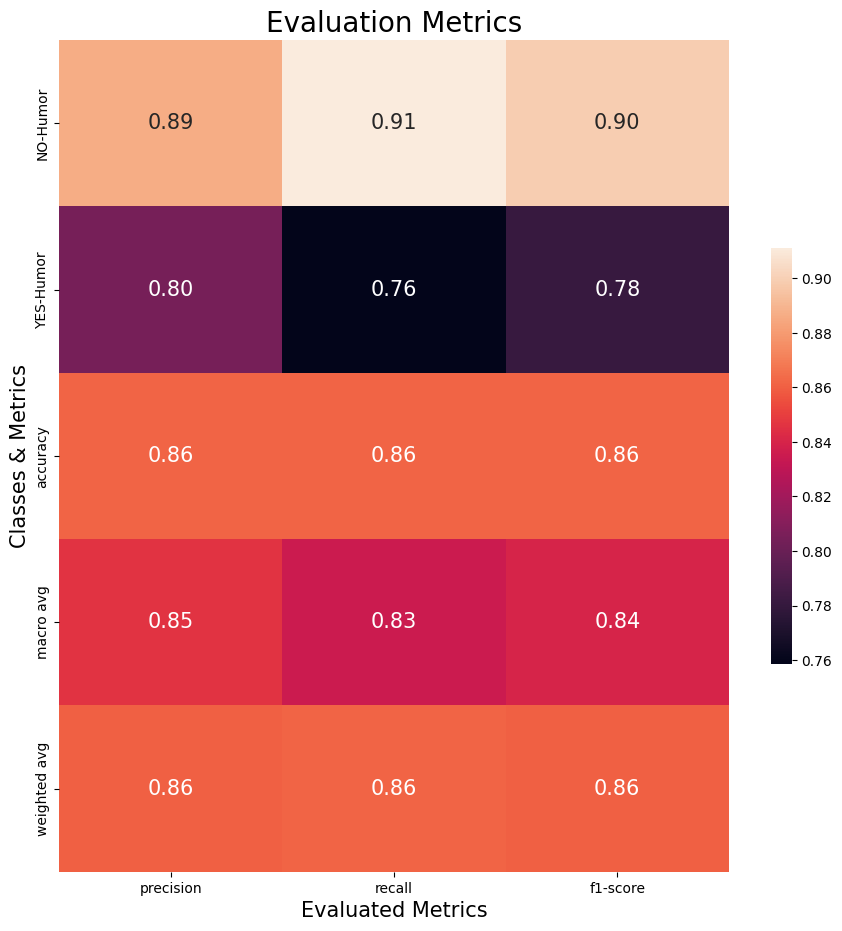

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
labels = ["NO-Humor", "YES-Humor"]
cr_str = classification_report(y_true=test["label"].tolist(), y_pred=test["predicted_label"].tolist(), target_names=labels)
cr = classification_report(y_true=test["label"].tolist(), y_pred=test["predicted_label"].tolist(), target_names=labels, output_dict=True)

fig_cr = plt.figure(figsize = (10.8, 10.8))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot = True, fmt = ".2f", cbar_kws = {"shrink" : 0.5}, annot_kws = {"size": 15})
plt.xlabel("Evaluated Metrics", fontsize = 15)
plt.ylabel("Classes & Metrics", fontsize = 15)
plt.title("Evaluation Metrics", fontsize = 20)

# Save CR
fig_cr.savefig(os.path.join(PATH, "CLASSIFICATION_REPORT.png"))
plt.show()

In [ ]:
# Dump classification report
with open(os.path.join(PATH, "classification-report.txt"), "w") as f:
  f.write(cr_str)

## Confusion matrix

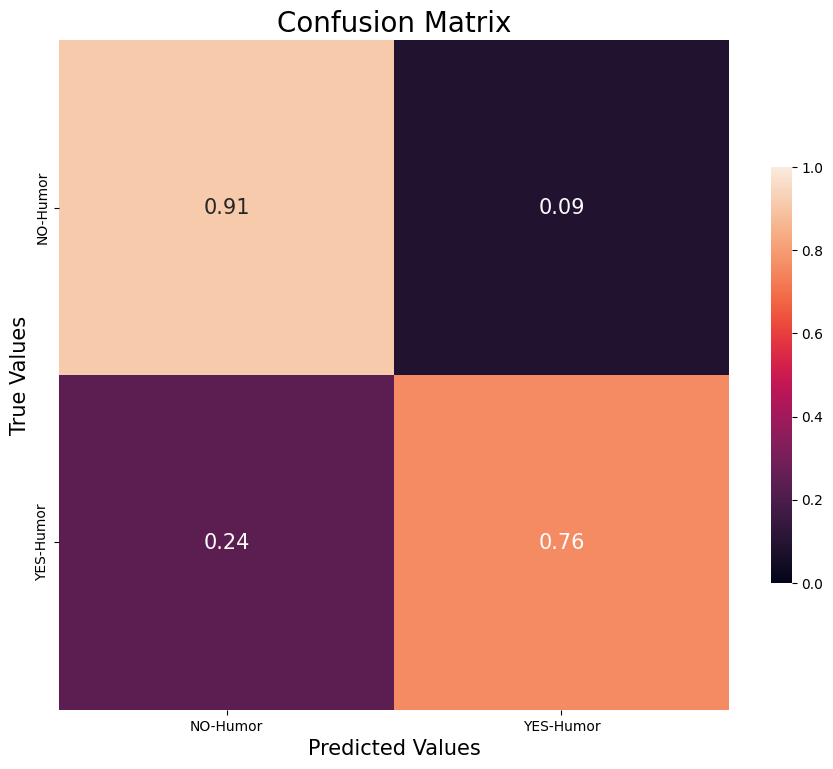

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

LABELS = ["NO-Humor", "YES-Humor"]
fig_cm = plt.figure(figsize = (10.8, 10.8))
cm = confusion_matrix(test.get("label"), test.get("predicted_label"), normalize = "true")
sns.heatmap(cm, vmin = 0, vmax = 1, square = True, annot = True, fmt = ".2f", cbar_kws = {"shrink" : 0.5}, xticklabels = LABELS, yticklabels = LABELS, annot_kws = {"size": 15})
plt.xlabel("Predicted Values", fontsize = 15)
plt.ylabel("True Values", fontsize = 15)
plt.title("Confusion Matrix", fontsize = 20)

# Save CM
fig_cm.savefig(os.path.join(PATH, "CONFUSION MATRIX.png"))
plt.show()

## ROC curve

<ipython-input-27-5b30798ed43f>:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve
<ipython-input-27-5b30798ed43f>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve


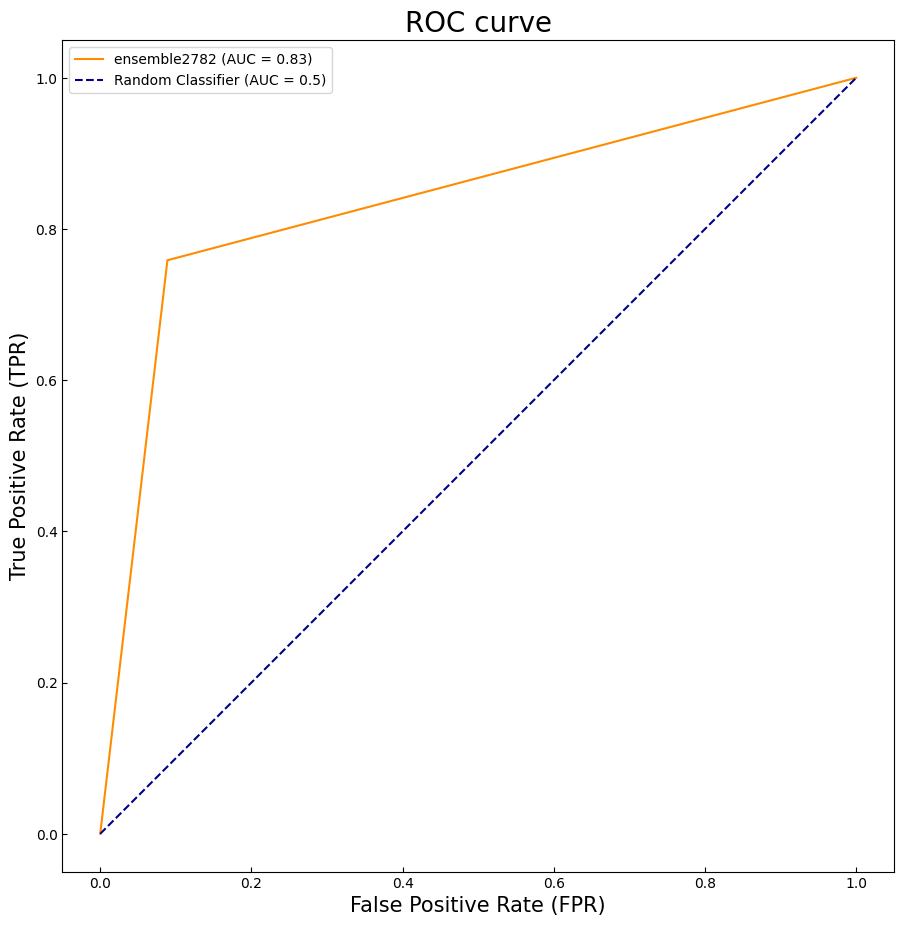

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig_roc = plt.figure(figsize = (10.8, 10.8))
fpr, tpr, _ = roc_curve(test["label"], test["predicted_label"])
plt.plot(fpr, tpr, color = "darkorange", label = "{} (AUC = {:0.2f})".format(best_ensemble.get("name"), auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve
plt.axis("square")
plt.xlabel("False Positive Rate (FPR)", fontsize = 15)
plt.ylabel("True Positive Rate (TPR)", fontsize = 15)
plt.title("ROC curve", fontsize = 20)
plt.tick_params(axis = "y",direction = "in")
plt.tick_params(axis = "x",direction = "in")
plt.legend()

# Save ROC curve
fig_roc.savefig(os.path.join(PATH, "ROC.png"))
plt.show()